This notebook demonstrates how to use the classes in `haloanalysis.model` to perform likelihood scans of the IGMF parameter space.  To start we construct the following:

* SED objects for the primary spectrum -- this potentially includes SEDs for both the TeV and GeV regimes
* SED for the cascade spectrum -- these are derived by fitting halo templates of varying sizes to LAT data
* A cascade model object -- this generates the predicted flux and angular size for a given choice of IGMF parameters and primary spectrum
* A spectrum object for the primary spectrum parameterization

These objects are then used to instantiate a `CascLike` object which is responsible for computing the total model likelihood from the sum of the primary and cascade likelihood functions.

In [38]:
%matplotlib inline
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.cm
from fermipy.spectrum import PLExpCutoff
from fermipy.castro import CastroData
from haloanalysis.model import make_prim_model, make_casc_model
from haloanalysis.model import CascModel, CascLike
from haloanalysis.utils import Axis, load_source_rows
from haloanalysis.sed import HaloSED, SED
import numpy as np

fn = PLExpCutoff([1E-13,-1.5,1E7],scale=1E3)

tab_tev = Table.read('../data/CompiledTeVSources.fits')
tab_tev = load_source_rows(tab_tev, ['1es0229+200'], key='SOURCE')
tab_casc = Table.read('1es0229_casc_sed.fits')
sed_prim = SED.create_from_row(tab_tev)
sed_casc = HaloSED.create_from_fits(tab_casc[0])
hmm = CascModel.create_from_fits('results.fits')
hl = CascLike(hmm, fn, sed_casc, sed_prim)

The `CascLike` class provides methods that can be used to evaluate the likelihood as a function of B-field parameters (`p0` argument) or primary spectrum parameters (`p1` argument).  Here we perform a likelihood scan as a function of B-field strength for several values of the coherence length scale.

(0, 100)

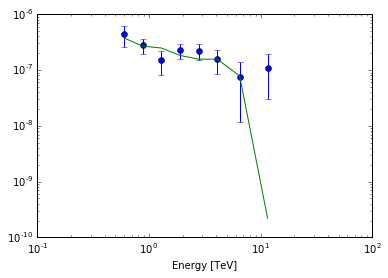

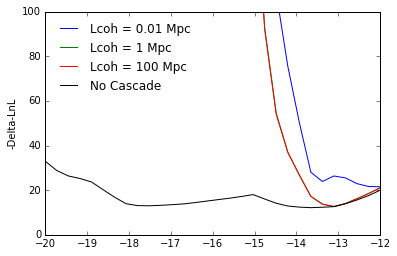

In [55]:

lnl, p1 = hl.fit([0.0,-16.0],fn.params,method='SLSQP',casc_scale=1E-6)
igmf = np.linspace(-20.0,-12.0,30)
lnl0 = hl.lnl([-2.0,igmf],p1)
lnl1 = hl.lnl([0.0,igmf],p1)
lnl2 = hl.lnl([2.0,igmf],p1)

lnl_null = hl.lnl([2.0,igmf],p1,casc_scale=1E-6)

plt.figure()
plt.errorbar(sed_prim.ectr/1E6,
             sed_prim.ectr*sed_prim.flux,
             sed_prim.ectr*sed_prim.flux_err,
             marker='o',linestyle='None')
plt.errorbar(sed_prim.ectr/1E6,
            sed_prim.ectr*hmm.prim_flux(fn,[0.0,-16.0],p1,axis_eobs=hl._axis_prim))
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Energy [TeV]')

plt.figure()
plt.plot(igmf,lnl0,label='Lcoh = 0.01 Mpc')
plt.plot(igmf,lnl1,label='Lcoh = 1 Mpc')
plt.plot(igmf,lnl2,label='Lcoh = 100 Mpc')
plt.plot(igmf,lnl_null,label='No Cascade',color='k')
plt.gca().legend(frameon=False,loc='upper left')
plt.gca().set_ylabel('-Delta-LnL')
plt.gca().set_ylim(0,100)


To derive constraints we need to profile the parameters of the primary spectrum at each point the IGMF parameter space.  Here we  build a 2D grid in Lcoh and B for the likelihood scan.  We fill an array with the cascade likelihood values by calling `CascLike.fit` at each point.  This method finds the best-fit parmeters of the primary spectrum given a set of IGMF parameters.

In [46]:
nstep = 11
lcoh_scan = np.linspace(-4,4,nstep)
igmf_scan = np.linspace(-20,-12,nstep)    
bpars = np.meshgrid(lcoh_scan, igmf_scan)

model_lnl = np.zeros(bpars[0].shape)*np.nan
p1 = fn.params

for idx, x in np.ndenumerate(bpars[0]):

    p0 = [bpars[0][idx], bpars[1][idx]]
    lnl, p1 = hl.fit(p0,p1,method='SLSQP')
    model_lnl[idx] = lnl


The following plot shows the negative delta-loglikelihood values for the scan.  

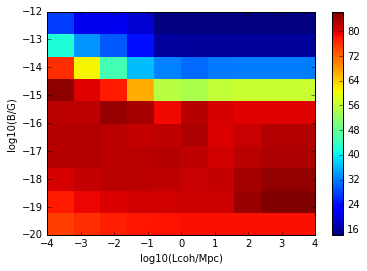

In [47]:
plt.figure()
plt.pcolormesh(bpars[0],bpars[1],model_lnl)
plt.gca().set_xlabel('log10(Lcoh/Mpc)')
plt.gca().set_ylabel('log10(B/G)')
plt.colorbar()